# **Use of SmartNoise Synthesizers**

- SmartNoise Synthesizers are a part of the SmartNoise system, which is developed to provide tools for data privacy and differential privacy in particular.

- Differential privacy is a framework for measuring the privacy guarantees provided by an algorithm.

- Through the use of SmartNoise Synthesizers, we can generate synthetic data that closely resembles your original dataset while still maintaining the privacy of individuals in the dataset.


In [1]:
!pip3 install antigranular

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.5 MB/s eta 0:00:00


In [3]:
import antigranular as ag
session = ag.login(<client_id>,<client_secret>, dataset = "Adult Population Dataset")

Dataset "Adult Population Dataset" loaded to the kernel as adult_population_dataset
Key Name                       Value Type     
---------------------------------------------
train_x                        PrivateDataFrame
train_y                        PrivateDataFrame
test_x                         DataFrame      

Connected to Antigranular server session id: 76f95af5-fc79-4268-a6f2-89b2cd6b4fe5, the session will time out if idle for 25 minutes
Cell magic '%%ag' registered successfully, use `%%ag` in a notebook cell to execute your python code on Antigranular private python server
🚀 Everything's set up and ready to roll!


# **Importing All Necessary Libraries**

In [ ]:
%%ag
import numpy as np
import op_snsynth

In [ ]:
%%ag
from op_snsynth import Synthesizer, TableTransformer

In [5]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches

# **SmartNoise Synthesizers**
- These synthesizers are a key component of the SmartNoise system. They generate synthetic data.

- By employing statistical models, these synthesizers create a new dataset that mimics the statistical properties of the original data but does not contain any actual data points from it. This synthetic data is then used for analysis or sharing instead of the original data.

- The synthetic data ensures that the privacy of individuals in the original dataset is maintained. Even if the synthetic data is analyzed or shared, it doesn't reveal information about any specific individual.

- This is especially useful in research and data analysis where sharing original data might be risky or prohibited due to privacy concerns.

- Despite the added noise, the synthetic data retains much of the utility of the original dataset, making it suitable for analysis.

- Helps organizations comply with data privacy regulations like GDPR, HIPAA, etc.

# **Limitations**

  - Synthetic data (differentially private or not) often loses nuances within the dataset due to the simplifications created during its training phase.

  - The limitations are thereby unknown and may cause bias in the resulting analysis.

  - While synthetic data protects privacy, the added noise might reduce the accuracy of the data for certain types of analysis.
  - Implementing differential privacy, especially in complex datasets, can be technically challenging.


## **Test real vs synthetic data**

- **Purpose**: To compare real and synthetic datasets by training a model on each and evaluating their performance.

- **Parameters**:

  `real`: The original, real dataset.
  
  `synthetic`: The synthetic dataset generated for comparison.
  
  `model`: A machine learning model for training and testing.
  
  `describe`: A flag to print descriptive statistics of both datasets.

In [ ]:
def test_real_vs_synthetic_data(real, synthetic, model):

  # Create a DataFrame for synthetic data with the same columns as the real data
  synth_df = pd.DataFrame(synthetic, columns=real.columns)

  # Split real and synthetic datasets into features and labels
  X = real.iloc[:, :-1]
  y = real.iloc[:, -1]
  X_synth = synth_df.iloc[:, :-1]
  y_synth = synth_df.iloc[:, -1]

  # Split both real and synthetic data into training and test sets
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  x_train_synth, x_test_synth, y_train_synth, y_test_synth = train_test_split(X_synth, y_synth, test_size=0.2, random_state=42)

  # Train model on real data
  model_real = model()
  model_real.fit(x_train, y_train)

  # Train model on synthetic data
  model_fake = model()
  model_fake.fit(x_train_synth, y_train_synth)

  # Evaluate and print performance of model trained on real data
  predictions = model_real.predict(x_test)
  print("\nTrained on Real Data:")
  print(classification_report(y_test, predictions))
  print("Accuracy real:", accuracy_score(y_test, predictions))

  # Evaluate and print performance of model trained on synthetic data
  predictions = model_fake.predict(x_test_synth)
  print("\nTrained on Synthetic Data:")
  print(classification_report(y_test_synth, predictions))
  print("Accuracy synthetic:", accuracy_score(y_test_synth, predictions))

  # Evaluate and print performance of random guessing
  print("\nRandom Guessing:")
  guesses = np.random.randint(0, (max(y_test_synth) - min(y_test_synth) + 1), len(y_test_synth))
  np.random.shuffle(guesses)
  print(classification_report(y_test_synth, guesses))
  print("Accuracy guessing:", accuracy_score(y_test_synth, guesses))

  return model_real, model_fake

def tsne_plot(real, synthetic):

    # Prepare DataFrame for synthetic data
    synth_df = pd.DataFrame(synthetic, columns=real.columns)

    # Select features from real and synthetic data for t-SNE visualization
    x_train = real.iloc[:, :-1]
    x_train_synth = synth_df.iloc[:, :-1]

    # Combine and apply t-SNE to the data
    comb = np.vstack((x_train[:500], x_train_synth[:500]))
    embedding_1 = TSNE(n_components=2, perplexity=5.0, early_exaggeration=1.0).fit_transform(comb)
    x, y = embedding_1.T

    # Splitting the transformed data into two parts for plotting
    l = int(len(x) / 2)

    # Set up the plot
    plt.rcParams["figure.figsize"] = (8,8)
    plt.scatter(x, y, c=['red' for _ in range(l)] + ['blue' for _ in range(l)])
    red_patch = mpatches.Patch(color='red', label='Real Data')
    blue_patch = mpatches.Patch(color='blue', label='Synthetic Data')

    plt.legend(handles=[red_patch, blue_patch])

    plt.title('TSNE Plot, Real Data vs. Synthetic')
    plt.show()

def plot_feature_boxplots(real, synthetic):

    # Convert synthetic data to DataFrame
    synth_df = pd.DataFrame(synthetic, columns=real.columns)

    # Initialize plot
    fig = plt.figure(figsize=(12, 8))
    cols = 5
    rows = math.ceil(float(real.shape[1]) / cols)
    color_dict = {'Real': '#1f77b4', 'Synthetic': 'orange'}

    # Create boxplot for each feature
    for i, column in enumerate(real.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        sns.boxplot(data=[real[column], synth_df[column]])
    plt.setp(ax, xticks=[0, 1], xticklabels=['Real', 'Synthetic'])

    # Add legend to the plot
    handles = [plt.Rectangle((0,0),1,1, color=color_dict[label], ec="k") for label in color_dict]
    labels= ["Real", "Synthetic"]
    fig.legend(handles, labels, loc='upper right')
    plt.subplots_adjust(hspace=0.4, wspace=0.7)
    plt.show()

# **Importing our dataset**

In [7]:
pums = pd.read_csv('https://content.antigranular.com/image/notebook_content/PUMS.csv')
session.private_import(data = pums, name= 'pums')

dataframe cached to server, loading to kernel...
Dataframe loaded successfully to the kernel



# **Preprocessing Privacy Budget**

- The synthesizer is designed to automatically process the data into a format appropriate for its specific type. For instance, the `mwem` synthesizer needs categorical variables to be integer-encoded, while the dpctgan synthesizer works with one-hot encoded categories.

- Sometimes, this preprocessing step might use a part of the privacy budget, especially in operations like binning or scaling continuous columns, where calculating approximate bounds incurs a privacy expense if bounds aren't predefined by the user.

- You can control the privacy budget allocation for preprocessing by using the `preprocessor_eps` parameter when calling the `Synthesizer.create()` method.

In [ ]:
%%ag

synth = Synthesizer.create("mwem", epsilon=1.0, iterations=6, verbose=True)
sample = synth.fit(pums, preprocessor_eps=0.1)

/code/dependencies/op_smartnoise/op_snsynth/mwem.py:363: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  self.histograms = self._histogram_from_data_attributes(self.data, self.splits)



Processing 1 histograms

Histogram #0 split: [0 1 2 3 4 5]
Columns: 6
Dimensionality: 308,352
Cuboids possible: 63
1-2-way cuboids possible: 21
Fitting for 6 iterations
Number of queries: 12
Number of slices in queries: 2428
Per-Measure Epsilon: 0.083
Measurement Error: 27.63


[0] - Average error: 1.656. Selected 6 slices

[1] - Average error: 0.991. Selected 32 slices

[2] - Average error: 0.849. Selected 73 slices

[3] - Average error: 0.769. Selected 16 slices

[4] - Average error: 0.692. Selected 12 slices

[5] - Average error: 0.519. Selected 22 slices



# **What do Other Synthesizers Do?**

The SmartNoise Synthesizers provide a variety of synthesizers for users to explore, other than `MWEM`. Here's a brief overview of each:

- **Marginal Synthesizers**:

  `AIM`: A synthesizer focusing on producing synthetic data while maintaining the marginal distributions of the original dataset.

  `MST`: Another marginal synthesizer that emphasizes on maintaining statistical properties of the data.

  `PAC-Synth`: A synthesizer designed to offer probably approximately correct (PAC) guarantees on the synthetic data generated.

- **Neural Network Synthesizers**:

  `DP-CTGAN`: A differentially private version of the Conditional Tabular Generative Adversarial Network (CTGAN).

  `PATE-CTGAN`: An extension of CTGAN, which incorporates Private Aggregation of Teacher Ensembles (PATE) for enhanced privacy.
  
  `PATE-GAN`: Utilizes the PATE framework in a GAN setting to generate synthetic data with privacy guarantees.
  
  `DP-GAN`: A differentially private Generative Adversarial Network tailored for generating synthetic datasets.

- **Hybrid Synthesizers**:

  `QUAIL`: A hybrid synthesizer that combines various techniques to balance between data utility and privacy.
  

Each of these synthesizers offers unique approaches to generating synthetic data while addressing different aspects of privacy and data utility.

# **Building the Synthetic Data and Plotting the graph**

In [ ]:
%%ag
sample_size = len(pums)
synthetic = synth.sample(int(sample_size))

In [ ]:
%%ag
export(synthetic, 'synthetic')

Setting up exported variable in local environment: synthetic


# **Why Use RidgeClassifier?**

- **Purpose**:

  The RidgeClassifier is a linear classification model that applies ridge regression. It is typically used when dealing with multi-collinearity in data, where it penalizes the size of the coefficients.
  
  In the context of this notebook, it is used for evaluating the quality or similarity of synthetic data against real data. The classifier would likely be trained on one dataset (either real or synthetic) and tested on the other to assess how well the synthetic data mimics the real data (as per your choice).

- **Expected Outcome**:

  It indicates how well the synthetic data replicates the characteristics of the real data. A high similarity in performance suggests that the synthetic data is a good representation of the real data, maintaining important patterns and distributions.

In [ ]:
test_real_vs_synthetic_data(pums, synthetic, RidgeClassifier)

               age          sex         educ         race        income  \
count  1000.000000  1000.000000  1000.000000  1000.000000    1000.00000   
mean     44.797000     0.514000     9.888000     1.954000   34380.08400   
std      17.745385     0.500054     3.415424     1.155517   51491.28621   
min      18.000000     0.000000     1.000000     1.000000       0.00000   
25%      31.000000     0.000000     9.000000     1.000000    6500.00000   
50%      42.000000     1.000000    11.000000     1.000000   19150.00000   
75%      55.000000     1.000000    13.000000     3.000000   41075.00000   
max      93.000000     1.000000    16.000000     6.000000  420500.00000   

           married  
count  1000.000000  
mean      0.549000  
std       0.497842  
min       0.000000  
25%       0.000000  
50%       1.000000  
75%       1.000000  
max       1.000000  
              age          sex         educ         race        income  \
count  1000.00000  1000.000000  1000.000000  1000.000000   10

(RidgeClassifier(), RidgeClassifier())

# **Inference from the plot**

- The t-Distributed Stochastic Neighbor Embedding (t-SNE) plot is a dimensionality reduction technique used to visualize high-dimensional data in two or three dimensions. In this plot, the red dots represent real data points, and the blue dots represent synthetic data points.

- Ideally, one would expect the red and blue dots to be intermixed and distributed similarly across the plot, indicating that the synthetic data closely matches the real data in the reduced-dimensional space.

- Here we observe that the red and blue dots seem to form distinct clusters, with some overlap. This suggests that while there is some degree of similarity between the real and synthetic data, there are also noticeable differences in their distributions.

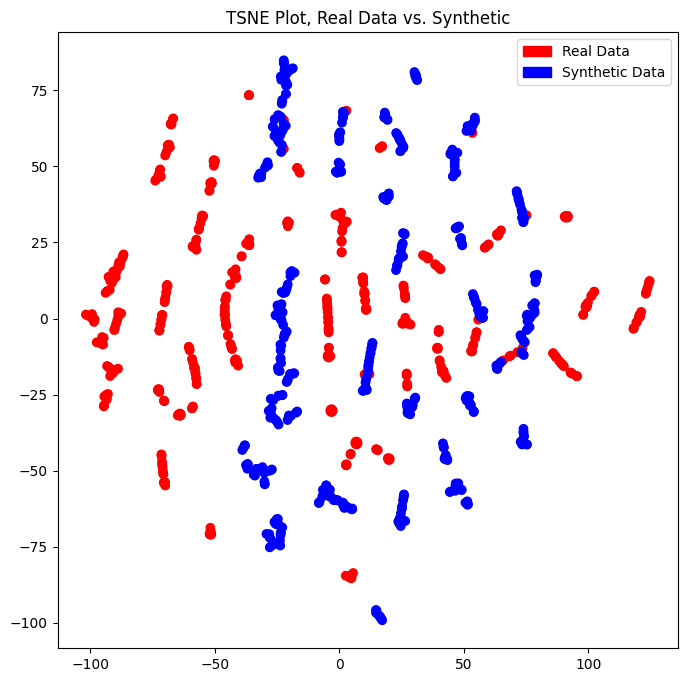

In [ ]:
# Call this only if you want to see the TSNE plot
tsne_plot(pums, synthetic)

# **Box plots outcome**

- The box plots provide a statistical summary of various features, comparing the real data (blue) and synthetic data (orange) across different variables such as age, sex, education, race, income, and marital status.

- The purpose here is to compare the central tendency and dispersion of real and synthetic data for various demographic and socio-economic variables.

- For a good synthetic dataset, the medians (central lines in the boxes), the interquartile ranges (heights of the boxes), and the ranges (whiskers) should be similar between the real and synthetic data.

- The box plots show a mix of results. For some variables like sex and married status, the synthetic data seems to replicate the real data closely, as indicated by the nearly identical bars. However, for other variables like age, education, and income, there are notable differences in the distribution, with the synthetic data showing more variance in some cases (e.g., income) and less in others (e.g., age).

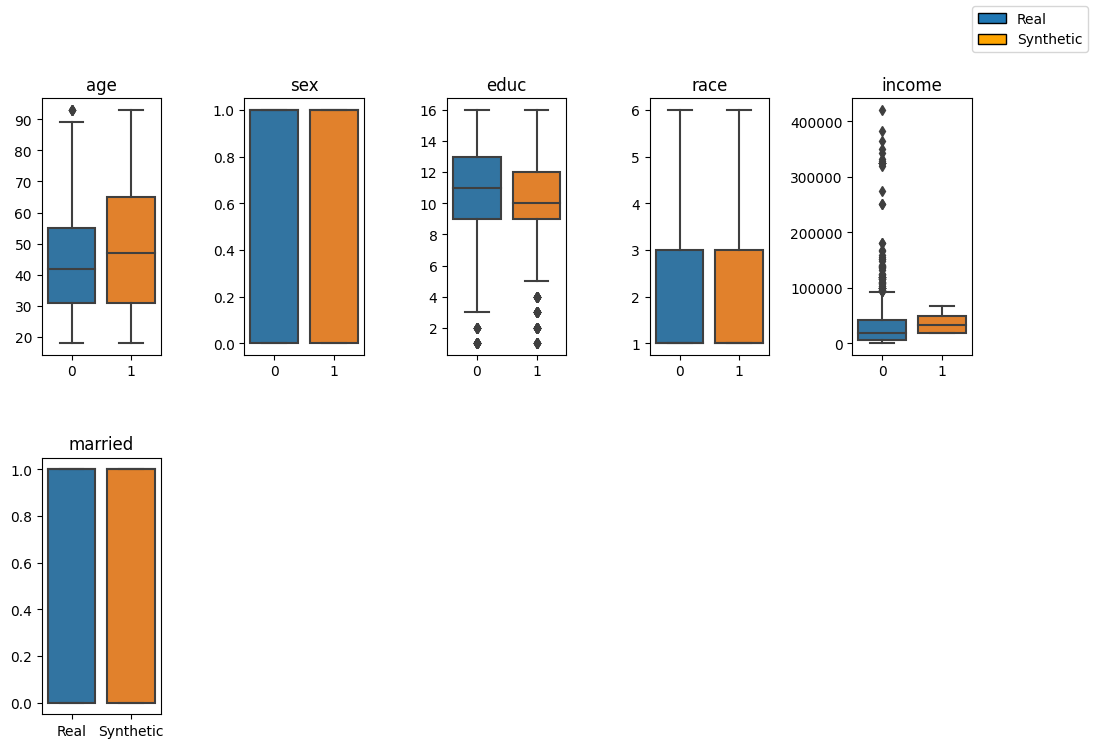

In [ ]:
# Call this only if you want to see the TSNE plot
plot_feature_boxplots(pums, synthetic)

In [ ]:
test_real_vs_synthetic_data(pums, synthetic, LogisticRegression)

               age          sex         educ         race        income  \
count  1000.000000  1000.000000  1000.000000  1000.000000    1000.00000   
mean     44.797000     0.514000     9.888000     1.954000   34380.08400   
std      17.745385     0.500054     3.415424     1.155517   51491.28621   
min      18.000000     0.000000     1.000000     1.000000       0.00000   
25%      31.000000     0.000000     9.000000     1.000000    6500.00000   
50%      42.000000     1.000000    11.000000     1.000000   19150.00000   
75%      55.000000     1.000000    13.000000     3.000000   41075.00000   
max      93.000000     1.000000    16.000000     6.000000  420500.00000   

           married  
count  1000.000000  
mean      0.549000  
std       0.497842  
min       0.000000  
25%       0.000000  
50%       1.000000  
75%       1.000000  
max       1.000000  
              age          sex         educ         race        income  \
count  1000.00000  1000.000000  1000.000000  1000.000000   10

(LogisticRegression(), LogisticRegression())

# **Using the MST Method**

- The acronym `MST` stands for **“Maximum-Spanning-Tree”** as the method produces differentially private synthetic data by relying on a “Maximum-Spanning-Tree" of mutual information.

- `MST` finds the maximum spanning tree on a graph where nodes are data attributes and edge weights correspond to approximate mutual information between any two attributes.

- We say approximate here, because the “maximum spanning tree” is built using the exponential mechanism, which helps select edge weights with high levels of mutual information in a differentially private manner. The marginals are measured using the `Gaussian` mechanism.

In [ ]:
%%ag

df = pums.drop(["income"], axis=1)
df = df.sample(frac=1, random_state=42)

In [ ]:
%%ag
mst_synth = Synthesizer.create("mst", epsilon=3.0, verbose=True)
sample = mst_synth.fit(df, preprocessor_eps=0.1)

Fitting with 28032 dimensions

Getting cliques

Estimating marginals



In [ ]:
%%ag
sample_size = len(df)
synth_data = mst_synth.sample(sample_size)

In [ ]:
%%ag
# import utils
export(synth_data, 'synth_data')
export(df, 'df')

Setting up exported variable in local environment: synth_data
Setting up exported variable in local environment: df


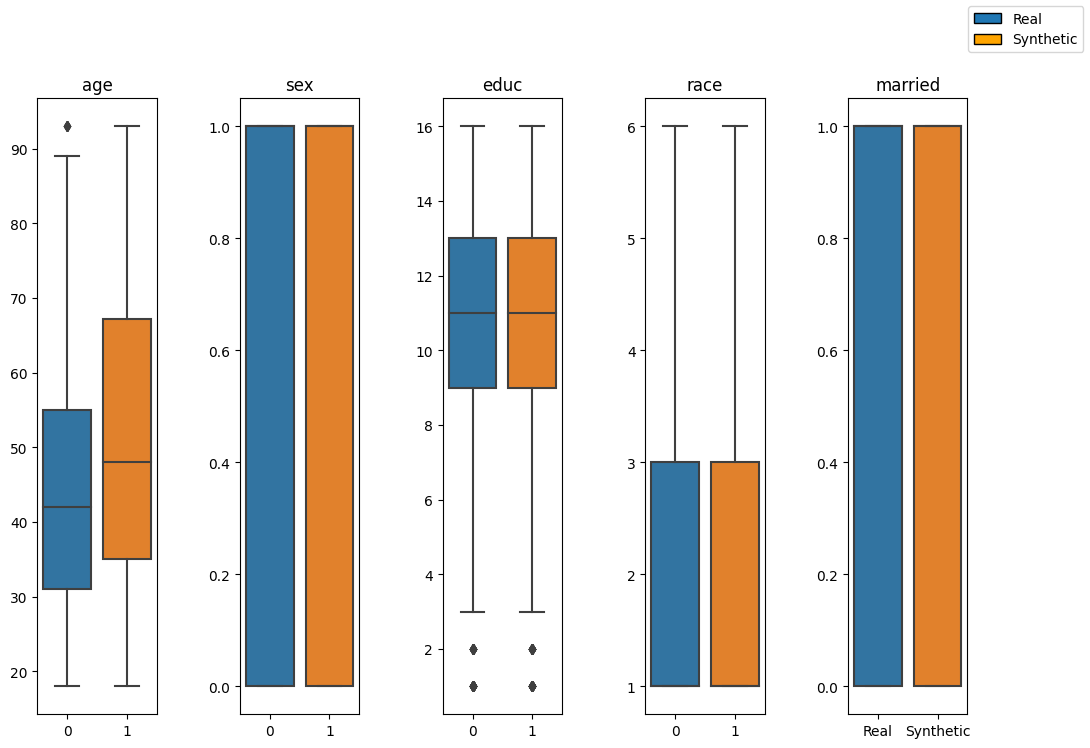

In [ ]:
# Call only if you want box plots
plot_feature_boxplots(df, synth_data)

# **What If We Use Data Transformers?**

- Even with `preprocessing hints`, the preprocessor inferred by the synthesizer may not be exactly what you want. For example, the `mwem` synthesizer will automatically bin continuous columns into 10 bins.

- Spending `epsilon` to infer bounds is wasteful and reduces accuracy when you already have public bounds for continuous columns. In most cases, you will get the best performance by manually specifying the preprocessor you want to use.

- Preprocessing is done by a `TableTransformer` object, which implements a differentially private reversible data transform.

In [ ]:
%%ag
# pums = pums.drop(['income', 'age'], axis=1)
cat_cols = list(pums.columns)

# **Inferring Bounds for Continuous Columns**

The `create` method can infer the min and max values from the data set. Inferring the min and max requires some privacy budget, specified by the `epsilon` argument.

In [ ]:
%%ag

tt = TableTransformer.create(pums, style='cube', categorical_columns=cat_cols, continuous_columns=['age', 'income'])
pums_encoded = tt.fit_transform(pums, epsilon=3.0)
pums_decoded = tt.inverse_transform(pums_encoded)

In [ ]:
%%ag
synth = Synthesizer.create("mwem", epsilon=1.0, iterations=6, verbose=True)
sample = synth.fit(pums_decoded, preprocessor_eps=0.1)

/code/dependencies/op_smartnoise/op_snsynth/mwem.py:363: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  self.histograms = self._histogram_from_data_attributes(self.data, self.splits)



Processing 1 histograms

Histogram #0 split: [0 1 2 3 4 5]
Columns: 6
Dimensionality: 308,352
Cuboids possible: 63
1-2-way cuboids possible: 21
Fitting for 6 iterations
Number of queries: 12
Number of slices in queries: 1443
Per-Measure Epsilon: 0.083
Measurement Error: 27.63


[0] - Average error: 2.006. Selected 11 slices

[1] - Average error: 1.532. Selected 6 slices

[2] - Average error: 0.832. Selected 16 slices

[3] - Average error: 0.636. Selected 4 slices

[4] - Average error: 0.346. Selected 22 slices

[5] - Average error: 0.321. Selected 32 slices



In [ ]:
%%ag
sample_size = len(pums_decoded)
synthetic_two = synth.sample(int(sample_size))

In [ ]:
%%ag
export(synthetic_two, 'synthetic_two')
export(pums_decoded, 'pums_decoded')

Setting up exported variable in local environment: synthetic_two
Setting up exported variable in local environment: pums_decoded


In [ ]:
test_real_vs_synthetic_data(pums_decoded, synthetic_two, RidgeClassifier)

               age          sex         educ         race        income  \
count  1000.000000  1000.000000  1000.000000  1000.000000    1000.00000   
mean     44.797000     0.514000     9.888000     1.954000   34380.08400   
std      17.745385     0.500054     3.415424     1.155517   51491.28621   
min      18.000000     0.000000     1.000000     1.000000       0.00000   
25%      31.000000     0.000000     9.000000     1.000000    6500.00000   
50%      42.000000     1.000000    11.000000     1.000000   19150.00000   
75%      55.000000     1.000000    13.000000     3.000000   41075.00000   
max      93.000000     1.000000    16.000000     6.000000  420500.00000   

           married  
count  1000.000000  
mean      0.549000  
std       0.497842  
min       0.000000  
25%       0.000000  
50%       1.000000  
75%       1.000000  
max       1.000000  
               age         sex         educ         race        income  \
count  1000.000000  1000.00000  1000.000000  1000.000000   10

(RidgeClassifier(), RidgeClassifier())

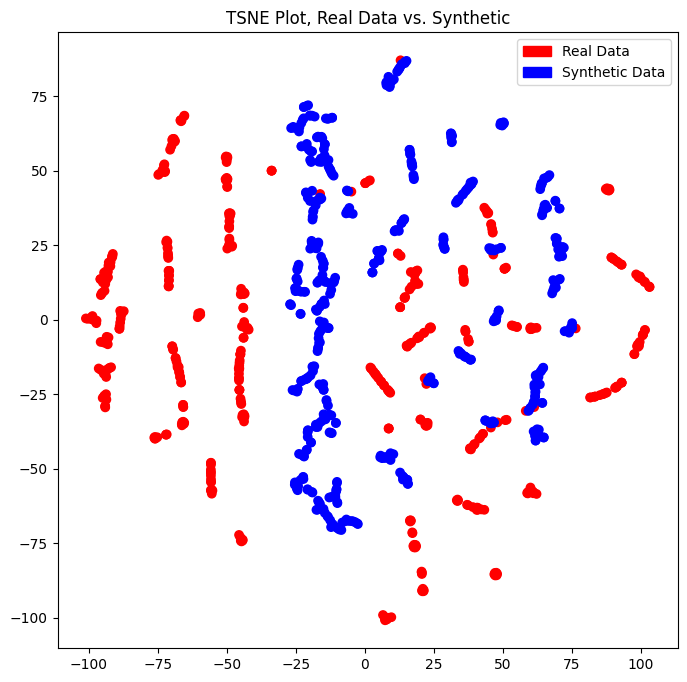

In [ ]:
# Call this only if you want to see the TSNE plot
tsne_plot(pums_decoded, synthetic_two)


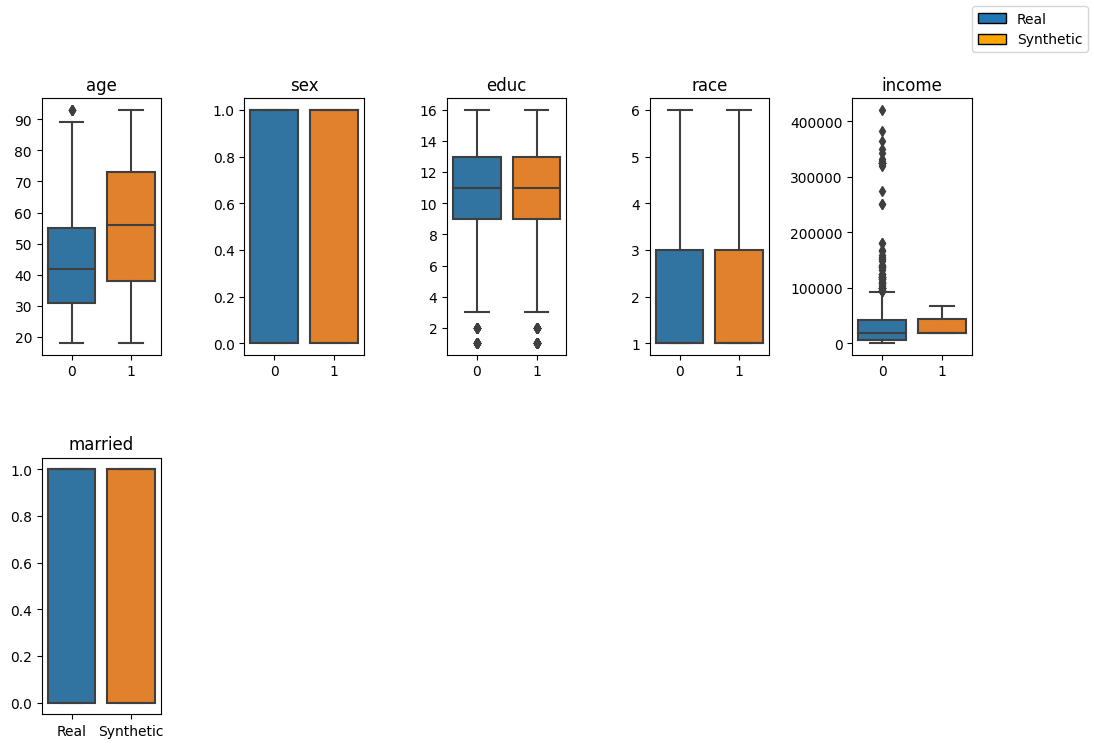

In [ ]:
# Call this only if you want to see the Box plot
plot_feature_boxplots(pums_decoded, synthetic_two)

# **Conclusion**

- In this notebook, we delved into the practical application of `SmartNoise Synthesizers`, a cornerstone of the SmartNoise system, designed to address the critical need for privacy in data analysis. Our journey began with an understanding of differential privacy, a framework essential for ensuring privacy guarantees in algorithms.

- Through a series of steps, we explored the capabilities of `SmartNoise Synthesizers` in generating synthetic data. This data, while mimicking the statistical properties of the original dataset, successfully maintains the privacy of individuals, showcasing the power of statistical models in creating privacy-preserving synthetic datasets.

- We witnessed how synthetic data can be utilized in different analytical contexts without risking the exposure of sensitive information. This aspect is particularly crucial in fields where data sharing is restricted or sensitive, such as healthcare, finance, and social research.

- Our analyses, including the use of visual tools like `t-SNE` and `box plots`, emphasized the effectiveness of SmartNoise Synthesizers in producing a viable alternative to real data.